In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from geographiclib.geodesic import Geodesic
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def ratr_contrails(time_horizon, sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails):
    ratr = 6.25e14 * sensitivity_rf_contrails * ratio_erf_rf_contrails * efficacy_erf_contrails / time_horizon**0.843
    return ratr

time_horizon = 100
ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1

In [3]:
def great_circle_path(lat1, lon1, lat2, lon2, npoints=100, waypoint=None):
    """
    Calcule une route orthodromique (great circle), avec possibilité d’un point de passage.
    
    Args:
        lat1, lon1 : coordonnées du point de départ (°)
        lat2, lon2 : coordonnées du point d’arrivée (°)
        npoints : nombre de points par segment
        waypoint : tuple (lat, lon) pour forcer un point de passage (optionnel)
    
    Returns:
        lats (np.array) : latitudes de la trajectoire
        lons (np.array) : longitudes de la trajectoire
        dists (np.array) : distances cumulées (km) le long de la trajectoire
        total_distance_km (float) : distance totale de la trajectoire (km)
    """
    geod = Geodesic.WGS84
    
    def segment(latA, lonA, latB, lonB, npoints):
        g = geod.Inverse(latA, lonA, latB, lonB)
        line = geod.Line(latA, lonA, g['azi1'])
        total_dist = g['s12']  # mètres
        dists = np.linspace(0, total_dist, npoints)
        
        lats, lons = [], []
        for d in dists:
            pos = line.Position(d)
            lats.append(pos['lat2'])
            lons.append(pos['lon2'])
        return np.array(lats), np.array(lons), dists / 1000.0, total_dist / 1000.0
    
    # Cas sans waypoint
    if waypoint is None:
        lats, lons, dists, total_dist = segment(lat1, lon1, lat2, lon2, npoints)
        return lats, lons, total_dist
    
    # Cas avec waypoint : deux segments
    latw, lonw = waypoint
    lats1, lons1, dists1, dist1 = segment(lat1, lon1, latw, lonw, npoints)
    lats2, lons2, dists2, dist2 = segment(latw, lonw, lat2, lon2, npoints)
    
    # Fusionner en enlevant le doublon du waypoint
    lats = np.concatenate([lats1, lats2[1:]])
    lons = np.concatenate([lons1, lons2[1:]])
    dists = np.concatenate([dists1, dist1 + dists2[1:]])
    total_distance_km = dist1 + dist2
    
    return lats, lons, total_distance_km

In [4]:
def mean_along_path(dataarray, lats, lons):
    """
    Calcule la valeur moyenne d'un champ (lat, lon) le long d'une trajectoire,
    en gérant automatiquement les conventions de coordonnées.
    
    Args:
        dataarray : xarray.DataArray 2D (lat, lon)
        lats, lons : arrays des coordonnées de la route (sorties great_circle_path)
        
    Returns:
        float : moyenne des valeurs interpolées le long de la trajectoire
        np.array : valeurs interpolées le long de la trajectoire
    """
    # Extraire lat/lon
    lat_vals = dataarray['lat'].values
    lon_vals = dataarray['lon'].values
    field = dataarray.values

    # 🔹 Vérif lat : doit être croissant pour l’interpolateur
    if lat_vals[0] > lat_vals[-1]:
        lat_vals = lat_vals[::-1]
        field = field[::-1, :]  # inverser l’ordre des latitudes
    
    # 🔹 Vérif lon : uniformiser
    if np.all(lon_vals >= 0):  
        # cas 0–360 → convertir les longitudes de la route
        lons_mod = np.mod(lons, 360)
    else:
        # cas -180–180 → convertir dans ce système
        lons_mod = np.where(lons > 180, lons - 360, lons)
    
    # Créer interpolateur
    interp = RegularGridInterpolator(
        (lat_vals, lon_vals), field,
        bounds_error=False, fill_value=np.nan
    )
    
    # Construire les points
    points = np.array([lats, lons_mod]).T
    
    # Interpoler
    values = interp(points)
    
    return np.nanmean(values), values

In [5]:
file_path = 'seg_length_km_GAIA_2019.nc'
dsl = xr.open_dataset(file_path)
print(dsl)

# Somme sur toutes les latitudes et longitudes pour chaque variable souhaitée
sum_seg_length_km = dsl['seg_length_km'].sum(dim=['lat', 'lon']).item()
sum_seg_length_contrail_km = dsl['seg_length_contrail_km'].sum(dim=['lat', 'lon']).item()

print(f"Somme seg_length_km: {sum_seg_length_km}")
print(f"Somme seg_length_contrail_km: {sum_seg_length_contrail_km}")

<xarray.Dataset> Size: 1MB
Dimensions:                 (lat: 180, lon: 360)
Coordinates:
  * lat                     (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                     (lon) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
Data variables:
    seg_length_km           (lat, lon) float64 518kB ...
    seg_length_contrail_km  (lat, lon) float64 518kB ...
Somme seg_length_km: 60929593892.37307
Somme seg_length_contrail_km: 12505560816.768536


In [6]:
file_path = 'EF_and_RF_per_contrail_length_2019.nc'
file_path = 'output_mean.nc'

In [7]:
ds = xr.open_dataset(file_path)
print(ds)

rfd_mean = (ds['RF_net'] * ds['areacella']).sum(dim=['lat', 'lon']) / ds['areacella'].sum(dim=['lat', 'lon']) /sum_seg_length_km
print(rfd_mean)

atr_mean = ratr_contrails(time_horizon, rfd_mean, ratio_erf_rf_contrails, efficacy_erf_contrails)
print(atr_mean)

new_var_data = ds['RF_net'] / dsl['seg_length_km']
ds['RFD'] = new_var_data

print(ds['RFD'].where(np.isfinite(ds['RFD']), np.nan).mean().item())
print(ds['RF_lin'].where(np.isfinite(ds['RF_lin']), np.nan).mean().item())

rf_lin_cleaned = ds['RFD'].where(np.isfinite(ds['RFD']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon']) * dsl['seg_length_km'] / sum_seg_length_km

rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
mean_rf_transformed = rf_transformed.sum().item()
print(mean_rf_transformed)

<xarray.Dataset> Size: 3MB
Dimensions:       (lat: 180, lon: 360)
Coordinates:
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon           (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    RF_net        (lat, lon) float32 259kB ...
    areacella     (lat, lon) float64 518kB ...
    EF            (lat, lon) float64 518kB ...
    RF_lin_cotra  (lat, lon) float64 518kB ...
    RF_lin        (lat, lon) float64 518kB ...
    EF_lin_cotra  (lat, lon) float64 518kB ...
    EF_lin        (lat, lon) float64 518kB ...
<xarray.DataArray ()> Size: 8B
array(7.22283243e-13)
<xarray.DataArray ()> Size: 8B
array(3.90694095)
4.422215558020547e-07
4.422215564050804e-07
3.906683011094492


In [8]:
# rf_transformed est un xarray.DataArray
rf_lin_cleaned = ds['RFD'].where(np.isfinite(ds['RFD']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
data = rf_transformed

atr_i = rf_transformed * dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan) / sum_seg_length_km
mean_atr = atr_i.sum().item()
print(mean_atr)

3.906683011094492


## Application

Flight distance: 9107.091846262843 km
CO2 emissions: 637.4964292383991 kgCO2/PAX (for 70 gCO2/RPK)
Contrails equivalent emissions: 260.5461813866591 kgCO2-eq/PAX (for 300 passengers per aircraft)
Total equivalent emissions: 898.0426106250582 kgCO2-eq/PAX


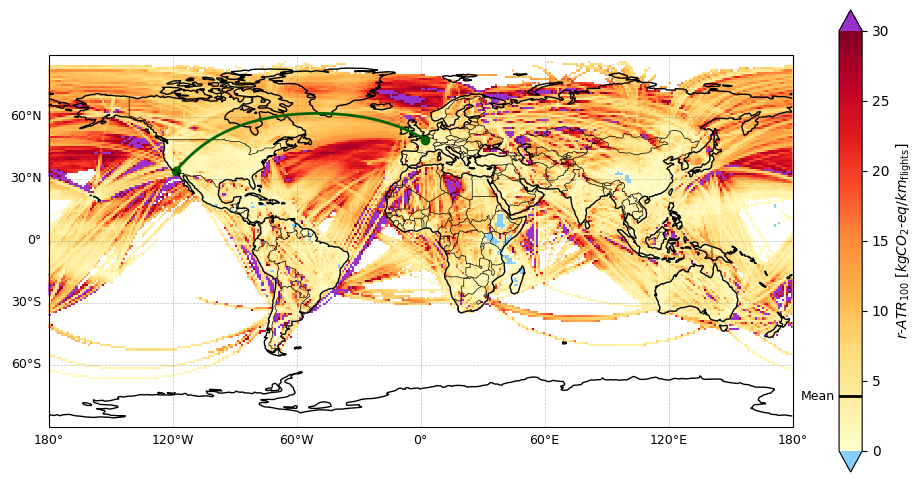

In [19]:
# Exemple : Paris (48.8566, 2.3522) -> New York (40.7128, -74.0060)
lat_paris, lon_paris = 48.8566, 2.3522 # Paris
lat_newyork, lon_newyork = 40.7128, -74.0060 # New York
lat_singapour, lon_singapour = 1.3521, 103.8198 # Singapour
lat_noumea, lon_noumea = -22.2711, 166.4410 # Nouméa
lat_tokyo, lon_tokyo = 35.6895, 139.6917 # Tokyo
lat_bogota, lon_bogota = 4.7110, -74.0721  # Bogota
lat_addis_abeba, lon_addis_abeba = 9.0320, 38.7469  # Addis-Abeba
lat_bangkok, lon_bangkok = 13.7563, 100.5018  # Bangkok
lat_los_angeles, lon_los_angeles = 34.0522, -118.2437  # Los Angeles

lat1, lon1 = lat_paris, lon_paris
lat2, lon2 = lat_noumea, lon_noumea
waypoint = (lat_singapour, lon_singapour) # None
waypoint = None
lat2, lon2 = lat_los_angeles, lon_los_angeles

lats, lons, total_dist_km = great_circle_path(lat1, lon1, lat2, lon2, waypoint=waypoint)


# Calculations
print("Flight distance:", total_dist_km, "km")
emission_index = 70
co2_emissions = total_dist_km * emission_index/1000
print("CO2 emissions:", float(co2_emissions), "kgCO2/PAX (for", emission_index, "gCO2/RPK)")
mean, values = mean_along_path(data, lats, lons)
nb_pax = 300
contrails_emissions = mean * total_dist_km / nb_pax # kgCO2-eq
print("Contrails equivalent emissions:", float(contrails_emissions), "kgCO2-eq/PAX (for", nb_pax, "passengers per aircraft)")
print("Total equivalent emissions:", float(co2_emissions+contrails_emissions), "kgCO2-eq/PAX")



# Tracé

Y = 1e4
data_masked = data.where(dsl['seg_length_km'] >= Y)

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data_masked.values
# Choix des bornes sur les valeurs positives uniquement
vmin = 0
vmax = 30

# Copier les données pour modifier
plot_data = data_np.copy()

# Norme sym log avec prise en compte de la valeur spéciale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Colormap avec NaN blanc et valeurs < vmin (négatifs) en noir
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))   # NaN en blanc
cmap.set_under('lightskyblue')       # valeurs sous vmin (négatifs) en bleu
cmap.set_over('darkorchid')

# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}


pcm = ax.pcolormesh(data['lon'], data['lat'], plot_data,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, extend='both')
cbar.ax.axhline(mean_atr, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_atr, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label(r"$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/km_{\text{flights}}$]", fontsize=10)

ax.plot(lons, lats, color='darkgreen', linestyle="-", transform=ccrs.Geodetic(), label="Great Circle", linewidth=2)
ax.scatter(lon1, lat1, color='darkgreen')
ax.scatter(lon2, lat2, color='darkgreen')

#plt.savefig("map1.pdf")
plt.show()

In [15]:
# Crée un masque booléen
mask = data_masked >= 20

# Nombre de valeurs supérieures à vmin
count_sup = mask.sum().item()  # .item() pour obtenir un int

# Nombre total de valeurs non-NaN
total = data_masked.count().item()

# Fraction / pourcentage
fraction = count_sup / total
print(f"{count_sup}/{total} ({fraction:.2%})")

4409/37837 (11.65%)
